# Eurovision 2022 (Draft Notebook)


## Potential Research Questions

1. Are Jury Voters less affected by Cultural Influences in Eurovision ?
2. [Needs to be Formulated Well] Does a sympathy-wave effect for Ukraine exist in 2022 Eurovision results?  How can we account for that?


## Plan

### 1. Pre-Analysis or Exploratory Data Analysis

Worth doing again, with newer data.

1. Basically, redo figure 7 from the paper with the newest data

## 2. Agent-Based Models

1. Null Model
2. Model 1
3. Cultural Affinity Model
   a. Cultural Affinity Model part 2


## 3. Find Best Fit

1. Kolmogorov-Smirnov test
2. Hypothesis: Simulated and Empirical FoF come from the same distribution.
    3. This was rejected in the original paper
    
    
### Further Work
1. Consider doing section 5
2. Ambitious: Section 6


Suggestion: Focus on the ABMs as opposed to fully recreating the full paper (K-S tests etc.) 
Also try various things:  subsets of networks.  what happens if you take away a node etc etc.  Give extra weight to Ukraine itself?

In [55]:
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Model, Agent
from mesa.time import RandomActivation
#import pyvis.network as pyvisnetwork
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector


from scipy.stats import rankdata
from scipy.stats import ks_2samp

# 1. Exploratory Data Analysis

First, we load the data for the various years and then visualize the network for a given year

In [56]:
#df = pd.read_excel('https://query.data.world/s/cuokq5sbbqlogvjrdwdeacvp367xnq')
df = pd.read_csv("data/dataworld.csv")
df

,Unnamed: 0.1,Unnamed: 0,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


In [57]:
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={
    "(semi-) final": "semi_or_final",
    "Jury or Televoting": "jury_or_televoting",
    "From country": "from",
    "To country": "to",
    "Points": "points"
}, inplace=True)

In [58]:
df_finals = df[df["semi_or_final"] == 'f']
df_finals_televoting = df_finals[df_finals["jury_or_televoting"] == "T"]
df_finals_jury = df_finals[df_finals["jury_or_televoting"] == "J"]


display(df_finals_televoting)
display(df_finals_jury)

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
36352,36352,36352,2016,f,2016f,T,Albania,Armenia,2,NaN
36353,36353,36353,2016,f,2016f,T,Albania,Australia,12,NaN
36354,36354,36354,2016,f,2016f,T,Albania,Austria,0,NaN
36355,36355,36355,2016,f,2016f,T,Albania,Azerbaijan,0,NaN
36356,36356,36356,2016,f,2016f,T,Albania,Belgium,0,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56283,56283,56283,2022,f,2022f,J,United Kingdom,Serbia,1,NaN
56284,56284,56284,2022,f,2022f,J,United Kingdom,Spain,10,NaN
56285,56285,56285,2022,f,2022f,J,United Kingdom,Sweden,12,NaN
56286,56286,56286,2022,f,2022f,J,United Kingdom,Switzerland,2,NaN


Let's visualize!

# Agent Based Modelling

In [59]:
SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])
alpha = 0.1

In [60]:
def calc_All_FoF(df, from_country, points_column = "points", FoF_column = "FoF"):
    Voter_selector = df["from"] == from_country

    voting_countries_2022 = df["from"].unique()


    N = len(voting_countries_2022)
    
    for to_country in df["to"].unique():
        Candidate_selector = df["to"] == to_country

        final_score = sum(df.loc[Candidate_selector, points_column])

        points = df.loc[Voter_selector & Candidate_selector, points_column]

        df.loc[Voter_selector & Candidate_selector, FoF_column ] =  ( points / 12 ) - ( ( final_score - points )/( 12*(N-2) ) )

## Null Model

In this null model, countries freely vote for other countries.  The only restriction is that they can assign only a fixed amount of points

In [61]:
class NullVotingAgent(Agent):
    
    def __init__(self, unique_id, model, df):
        '''
         Create a new Null Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        self.df = df
        
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        #print(f"Country {self.unique_id} is now voting")
        
        country_row_selector = self.df["from"] == self.unique_id

        fit = np.random.uniform(0, 1, size=len( self.df[country_row_selector] ))

        points_given = 58 * (fit/sum(fit))
        
        #print(f"{voting_country=}, {points_given=}")
        self.df.loc[country_row_selector, "null_model_points"] += points_given

In [62]:
def get_null_model_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["null_model_FoF"]
    
    return ks_2samp(data1, data2)

class NullVotingModel(Model):
    
    def __init__(self, jury_or_televoting, year):
        '''
        Create a new NullVotingModel model.

         Args:
            jury_or_televoting: a string with values  
                * J: Jury
                * T: Televoting
            year: year of competition
        '''
        
        super().__init__()
        
        df_finals_type = df_finals[df_finals["jury_or_televoting"] == jury_or_televoting]
        df_finals_televoting_year = df_finals_type[df_finals_type["Year"]==year].copy()

        self.df = df_finals_televoting_year
        
        self.datacollector = DataCollector(
            model_reporters={"ks": get_null_model_ks}
        )
        
        self.schedule = RandomActivation(self)
        
        
        self.df["null_model_points"] = 0
        self.df["FoF"] = 0
        self.df["null_model_FoF"] = 0

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            the_agent = NullVotingAgent(voting_country, self, self.df)
            self.schedule.add(the_agent)
            

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        
        
        self.schedule.step()
        
        #print("Going to start calc all the FoF")
        for voting_country in self.df["from"].unique():
            calc_All_FoF(self.df, voting_country, 'points', "FoF")        
            calc_All_FoF(self.df, voting_country, 'null_model_points', "null_model_FoF")
            
        self.datacollector.collect(self)

## Model1 ABM
This model also gives points at random, but follows the rules of the contest

In [63]:
class Model1Agent(Agent):
    
    def __init__(self, unique_id, model, df):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        self.df = df
        
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        country_row_selector = self.df["from"] == self.unique_id

        fit = pd.Series( np.random.uniform(0, 1, size=len(self.df[country_row_selector])) )
        rank = fit.rank(ascending=False)
        points_given = rank.apply(
            lambda x: SCORES[int(x) - 1] if x <= 10 else 0
        )
        
        #print(f"{rank=}, {voting_country=}, {type(points_given)=}")
        self.df.loc[country_row_selector, "model1_points"] += points_given.to_numpy()

In [64]:
def get_model1_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["model1_FoF"]
    
    return ks_2samp(data1, data2)


class Model1Model(Model):
    
    def __init__(self, jury_or_televoting, year):
        '''
        Create a new NullVotingModel model.

         Args:
            jury_or_televoting: a string with values  
                * J: Jury
                * T: Televoting
            year: year of competition
        '''
        
        super().__init__()
        
        df_finals_type = df_finals[df_finals["jury_or_televoting"] == jury_or_televoting]
        df_finals_televoting_year = df_finals_type[df_finals_type["Year"]==year].copy()

        self.df = df_finals_televoting_year
        
        self.datacollector = DataCollector(
            model_reporters={"ks": get_model1_ks}
        )
        
        self.df["model1_points"] = 0
        
        self.schedule = RandomActivation(self)
        

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            a = Model1Agent(voting_country, self, self.df)
            self.schedule.add(a)
            

    def step(self):
        '''
        Run one step of the model.
        '''
        
        self.schedule.step()
        
        #print("Going to start calc all the FoF")
        for voting_country in self.df["from"].unique():
            calc_All_FoF(self.df, voting_country, 'points', "FoF")        
            calc_All_FoF(self.df, voting_country, 'model1_points', "model1_FoF")
            
        self.datacollector.collect(self)

## Affinity Model

In [65]:
class AffinityModelAgent(Agent):
    
    def __init__(self, unique_id, model, df, alpha, cultural_network):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        self.df = df
        self.cultural_network = cultural_network
        self.alpha = alpha
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        country_row_selector = self.df["from"] == self.unique_id
        
        def affinity_fit(row):
            '''
                row: a dataframe row
            '''
            q = float(self.df["relative_score"].sample(1))

            from_country = row['from']
            to_country = row['to']


            network_part = nx.get_edge_attributes(self.cultural_network, "weight")[(from_country, to_country)]

            the_fit = self.alpha * q + network_part * (1 - self.alpha)

            return the_fit

        
        country_df = self.df[country_row_selector]

        fit = country_df.apply(
            lambda row: affinity_fit(row), axis=1
        )
        #print(f"{unique_id=}, {fit=}")
        rank = fit.rank(ascending=False)
        points_given = rank.apply(
            lambda x: SCORES[int(x) - 1] if x <= 10 else 0
        )
        
        self.df.loc[country_row_selector, "affinity_model_points"] += points_given.to_numpy()


In [66]:
def get_affinity_ks(model):
    
    data1 = model.df["FoF"]
    data2 = model.df["affinity_model_FoF"]
    
    return ks_2samp(data1, data2)


class AffinityModel(Model):
    
    def __init__(self,jury_or_televoting, year, mu, sigma, alpha):
        '''
        Create a new NullVotingModel model.

         Args:
        '''
        
        super().__init__()
        
        self.datacollector = DataCollector(
            model_reporters={"ks": get_affinity_ks}
        )

        
        df_finals_type = df_finals[df_finals["jury_or_televoting"] == jury_or_televoting]
        df_finals_televoting_year = df_finals_type[df_finals_type["Year"]==year].copy()
        self.df = df_finals_televoting_year
        
        self.df["affinity_model_points"] = 0
        
        self.df["relative_score"] = self.df["points"]/sum(self.df["points"])
        
        
        self.cultural_network = nx.from_pandas_edgelist(
            self.df,
            source="from",
            target="to",
            create_using=nx.DiGraph()
        )

        self.mu = mu
        self.sigma = sigma
        self.alpha = alpha

        dict_weight = {}
        for edge in self.cultural_network.edges():
            sampled_weight = np.random.normal(mu, sigma)
            dict_weight[edge] = sampled_weight
        nx.set_edge_attributes(self.cultural_network, values = dict_weight, name = 'weight')
        
        

        voting_countries = self.df["from"].unique()
        
        self.schedule = RandomActivation(self)

        for voting_country in voting_countries:
            a = AffinityModelAgent(voting_country, self, self.df, self.alpha, self.cultural_network)
            self.schedule.add(a)
            

    def step(self):
        '''
        Run one step of the model.
        '''
        
        self.schedule.step()
        
        #print("Going to start calc all the FoF")
        for voting_country in self.df["from"].unique():
            calc_All_FoF(self.df, voting_country, 'points', "FoF")        
            calc_All_FoF(self.df, voting_country, 'affinity_model_points', "affinity_model_FoF")
            
        self.datacollector.collect(self)

# 3. Run the ABMs in a batch for various years



# 4. Friend-Or-Foe for the ABMS

Now that we have Various models and also empirical data, we can calculate the Friend-or-Foe coefficients for each of them

## Batch Run

In [67]:
params_null = {
    "jury_or_televoting": "T",
    "year": [2021, 2022]    # 2020 Contest was cancelled due to COVID-19
}

In [68]:
from mesa.batchrunner import batch_run

#results = batch_run(
#    NullVotingModel,
#    parameters=params_null,
#    iterations=10,
#    max_steps=1,
#    number_processes=None,
#    data_collection_period=-1,
#    display_progress=True,
#)

In [69]:
#res_null = pd.DataFrame(results)
#res_null.to_csv("res_null.csv")

In [70]:
res_null = pd.read_csv("res_null.csv")
display(res_null)

,Unnamed: 0,RunId,iteration,Step,jury_or_televoting,year,ks_statistic,ks_pval
0,0,0,0,1,T,2021,0.246964,7.443150e-27
1,1,1,0,1,T,2022,0.189744,9.360958e-16
2,2,2,0,1,J,2022,0.210256,2.826301e-19
3,3,3,0,1,J,2021,0.218623,4.330497e-21
4,4,4,0,1,T,2016,0.236398,1.567102e-26
5,5,5,0,1,T,2019,0.226488,7.876122e-24
6,6,6,0,1,T,2017,0.276557,3.705405e-37
7,7,7,1,1,T,2016,0.242964,5.124098e-28
8,8,8,1,1,T,2019,0.225528,1.247297e-23
9,9,9,1,1,T,2017,0.247253,1.044989e-29


In [102]:
df_null_2021_T = res_null[(res_null["year"] == 2021) & (res_null["jury_or_televoting"] == "T")]
df_null_2022_T = res_null[(res_null["year"] == 2021) & (res_null["jury_or_televoting"] == "T")]

df_null_2021_J = res_null[(res_null["year"] == 2021) & (res_null["jury_or_televoting"] == "J")]
df_null_2022_J = res_null[(res_null["year"] == 2021) & (res_null["jury_or_televoting"] == "J")]

kses_2021 = df_null_2021_T["ks_statistic"]
kses_2022 = df_null_2022_T["ks_statistic"]

kses_2021_j = df_null_2021_J["ks_statistic"]
kses_2022_j = df_null_2022_J["ks_statistic"]

In [103]:
df_null_2021_T.loc[kses_2021.idxmin()]

Unnamed: 0                  48
RunId                       48
iteration                    4
Step                         1
jury_or_televoting           T
year                      2021
ks_statistic          0.224696
ks_pval                    0.0
Name: 48, dtype: object

In [104]:
df_null_2021_J.loc[kses_2021_j.idxmin()]

Unnamed: 0                  33
RunId                       33
iteration                    2
Step                         1
jury_or_televoting           J
year                      2021
ks_statistic          0.196356
ks_pval                    0.0
Name: 33, dtype: object

In [101]:
df_null_2022_T.loc[kses_2022.idxmin()]

Unnamed: 0                  48
RunId                       48
iteration                    4
Step                         1
jury_or_televoting           T
year                      2021
ks_statistic          0.224696
ks_pval                    0.0
Name: 48, dtype: object

In [74]:
params_model1 = {
    "jury_or_televoting": "T",
    "year": [2021, 2022]    # 2020 Contest was cancelled due to COVID-19
}

In [75]:
from mesa.batchrunner import batch_run

#results = batch_run(
#    Model1Model,
#    parameters=params_model1,
#    iterations=10,
#    max_steps=1,
#    number_processes=None,
#    data_collection_period=-1,
#    display_progress=True,
#)

In [76]:
#res_model1 = pd.DataFrame(results)
#res_model1.to_csv("res_model1.csv")

In [77]:
res_model1 = pd.read_csv("res_model1.csv")
display(res_model1)

,Unnamed: 0,RunId,iteration,Step,jury_or_televoting,year,ks_statistic,ks_pval
0,0,0,0,1,J,2022,0.308718,1.993156e-41
1,1,1,0,1,T,2022,0.334359,1.159295e-48
2,2,2,0,1,T,2021,0.379555,8.778020e-64
3,3,3,0,1,J,2021,0.339069,1.012237e-50
4,4,4,0,1,T,2019,0.370441,5.353011e-64
5,5,5,0,1,J,2019,0.334933,3.689909e-52
6,6,6,0,1,T,2016,0.364916,1.722770e-63
7,7,7,1,1,T,2019,0.350288,4.049945e-57
8,8,8,1,1,T,2016,0.343340,4.242172e-56
9,9,9,0,1,J,2017,0.368132,3.351347e-66


In [105]:
df_model1_2021_T = res_model1[(res_model1["year"] == 2021) & (res_model1["jury_or_televoting"] == "T")]
df_model1_2022_T = res_model1[(res_model1["year"] == 2021) & (res_model1["jury_or_televoting"] == "T")]

df_model1_2021_J = res_model1[(res_model1["year"] == 2021) & (res_model1["jury_or_televoting"] == "J")]
df_model1_2022_J = res_model1[(res_model1["year"] == 2021) & (res_model1["jury_or_televoting"] == "J")]

kses_2021 = df_model1_2021_T["ks_statistic"]
kses_2022 = df_model1_2022_T["ks_statistic"]


kses_2021_j = df_model1_2021_J["ks_statistic"]
kses_2022_j = df_model1_2022_J["ks_statistic"]

In [106]:
df_model1_2021_T.loc[kses_2021.idxmin()]

Unnamed: 0                  37
RunId                       37
iteration                    3
Step                         1
jury_or_televoting           T
year                      2021
ks_statistic          0.375506
ks_pval                    0.0
Name: 37, dtype: object

In [107]:
df_model1_2021_J.loc[kses_2021_j.idxmin()]

Unnamed: 0                   3
RunId                        3
iteration                    0
Step                         1
jury_or_televoting           J
year                      2021
ks_statistic          0.339069
ks_pval                    0.0
Name: 3, dtype: object

In [95]:
df_model1_2022_T.loc[kses_2022.idxmin()]

Unnamed: 0                  37
RunId                       37
iteration                    3
Step                         1
jury_or_televoting           T
year                      2021
ks_statistic          0.375506
ks_pval                    0.0
Name: 37, dtype: object

In [81]:
params_affinity = {
    "jury_or_televoting": "T",
    "year": [2021, 2022],    # 2020 Contest was cancelled due to COVID-19
    "mu": np.linspace(-0.1, 0.1, 21),
    "sigma": np.linspace(0, 0.1, 21),
    "alpha": np.linspace(0, 0.5, 3)
} 

In [82]:
from mesa.batchrunner import batch_run
#
#results = batch_run(
#    AffinityModel,
#    parameters=params_affinity,
#    iterations=10,
#    max_steps=1,
#    number_processes=None,
#    data_collection_period=-1,
#    display_progress=True,
#)

In [83]:
#res_affinity = pd.DataFrame(results)
#res_affinity.to_csv("res_affinity.csv")

In [96]:
res_affinity = pd.read_csv("res_affinity.csv")

In [97]:
display(res_affinity)

,Unnamed: 0,RunId,iteration,Step,jury_or_televoting,year,mu,sigma,alpha,ks_statistic,ks_pval
0,0,0,0,1,T,2016,-0.1,0.10,0.50,0.528143,2.768433e-136
1,1,1,0,1,T,2016,-0.1,0.00,0.25,0.392120,1.611083e-73
2,2,2,0,1,T,2016,0.0,0.00,0.00,0.694184,4.796560e-246
3,3,3,0,1,T,2016,-0.1,0.00,0.00,0.694184,4.796560e-246
4,4,4,0,1,T,2016,-0.1,0.05,0.00,0.521576,9.661474e-133
...,...,...,...,...,...,...,...,...,...,...,...
1615,1615,1615,4,1,J,2022,0.1,0.05,0.50,0.494359,1.537304e-108
1616,1616,1616,4,1,J,2022,0.1,0.05,0.00,0.508718,3.062547e-115
1617,1617,1617,4,1,J,2022,0.1,0.10,0.00,0.480000,4.534451e-102
1618,1618,1618,4,1,J,2022,0.1,0.10,0.50,0.495385,5.198155e-109


In [109]:
df_affinity_2021_T = res_affinity[(res_affinity["year"] == 2021) & (res_affinity["jury_or_televoting"] == "T")]
df_affinity_2022_T = res_affinity[(res_affinity["year"] == 2022) & (res_affinity["jury_or_televoting"] == "T")]

df_affinity_2021_J = res_affinity[(res_affinity["year"] == 2021) & (res_affinity["jury_or_televoting"] == "J")]
df_affinity_2022_J = res_affinity[(res_affinity["year"] == 2022) & (res_affinity["jury_or_televoting"] == "J")]



kses_2021 = df_affinity_2021_T["ks_statistic"]
kses_2022 = df_affinity_2022_T["ks_statistic"]

kses_2021_j = df_affinity_2021_J["ks_statistic"]
kses_2022_j = df_affinity_2022_J["ks_statistic"]

In [110]:
df_affinity_2021_T.loc[kses_2021.idxmin()]

Unnamed: 0                1090
RunId                     1090
iteration                    3
Step                         1
jury_or_televoting           T
year                      2021
mu                         0.0
sigma                      0.0
alpha                     0.25
ks_statistic          0.374494
ks_pval                    0.0
Name: 1090, dtype: object

In [112]:
df_affinity_2021_J.loc[kses_2021_j.idxmin()]

Unnamed: 0                 614
RunId                      614
iteration                    1
Step                         1
jury_or_televoting           J
year                      2021
mu                         0.1
sigma                      0.0
alpha                      0.5
ks_statistic          0.342105
ks_pval                    0.0
Name: 614, dtype: object

In [111]:
df_affinity_2022_T.loc[kses_2022.idxmin()]

Unnamed: 0                 478
RunId                      478
iteration                    1
Step                         1
jury_or_televoting           T
year                      2022
mu                         0.1
sigma                      0.0
alpha                     0.25
ks_statistic          0.363077
ks_pval                    0.0
Name: 478, dtype: object

In [113]:
df_affinity_2022_J.loc[kses_2022_j.idxmin()]

Unnamed: 0                1270
RunId                     1270
iteration                    3
Step                         1
jury_or_televoting           J
year                      2022
mu                        -0.1
sigma                      0.0
alpha                     0.25
ks_statistic          0.313846
ks_pval                    0.0
Name: 1270, dtype: object

In [39]:
best_null_model = NullVotingModel(jury_or_televoting="T", year=2022)

best_null_model.step()

In [40]:
best_null_model.df

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,null_model_points,FoF,null_model_FoF
54387,54387,54387,2022,f,2022f,T,Albania,Armenia,0,NaN,2.184404,-0.046053,-0.004953
54388,54388,54388,2022,f,2022f,T,Albania,Australia,0,NaN,0.285183,-0.004386,-0.199755
54389,54389,54389,2022,f,2022f,T,Albania,Azerbaijan,0,NaN,3.794270,-0.006579,0.114436
54390,54390,54390,2022,f,2022f,T,Albania,Belgium,0,NaN,1.629674,-0.010965,-0.028607
54391,54391,54391,2022,f,2022f,T,Albania,Czech Republic,0,NaN,3.664962,-0.010965,0.104723
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN,3.195571,-0.407895,0.080345
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN,2.799258,-0.050439,0.042815
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN,3.363993,-0.050439,0.098529
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN,3.287735,0.000000,0.088968


In [41]:
FoF_true = best_null_model.df["FoF"]
FoF_pred = best_null_model.df["null_model_FoF"]

r2_score(FoF_true, FoF_pred)

-0.30569553535232674

R^2 of best Model1 2021

In [42]:
best_model1_model = Model1Model(jury_or_televoting="T", year=2021)

best_model1_model.step()

In [43]:
best_model1_model.df

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,model1_points,FoF,model1_FoF
50820,50820,50820,2021,f,2021f,T,Australia,Albania,0,NaN,8,-0.078829,0.430180
50821,50821,50821,2021,f,2021f,T,Austria,Albania,0,NaN,0,-0.078829,-0.254505
50822,50822,50822,2021,f,2021f,T,Azerbaijan,Albania,0,NaN,10,-0.078829,0.601351
50823,50823,50823,2021,f,2021f,T,Belgium,Albania,0,NaN,0,-0.078829,-0.254505
50824,50824,50824,2021,f,2021f,T,Bulgaria,Albania,0,NaN,0,-0.078829,-0.254505
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51803,51803,51803,2021,f,2021f,T,Spain,United Kingdom,0,NaN,0,0.000000,-0.168919
51804,51804,51804,2021,f,2021f,T,Sweden,United Kingdom,0,NaN,0,0.000000,-0.168919
51805,51805,51805,2021,f,2021f,T,Switzerland,United Kingdom,0,NaN,8,0.000000,0.515766
51806,51806,51806,2021,f,2021f,T,The Netherlands,United Kingdom,0,NaN,0,0.000000,-0.168919


In [44]:
FoF_true = best_model1_model.df["FoF"]
FoF_pred = best_model1_model.df["model1_FoF"]

r2_score(FoF_true, FoF_pred)

-1.8742911303682934

R^2 of best Model1 2022

In [45]:
best_model1_model_2022 = Model1Model(jury_or_televoting="T", year=2022)

best_model1_model.step()

In [46]:
best_model1_model.df

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,model1_points,FoF,model1_FoF
54387,54387,54387,2022,f,2022f,T,Albania,Armenia,0,NaN,0,-0.046053,-0.155702
54388,54388,54388,2022,f,2022f,T,Albania,Australia,0,NaN,0,-0.004386,-0.201754
54389,54389,54389,2022,f,2022f,T,Albania,Azerbaijan,0,NaN,2,-0.006579,-0.098684
54390,54390,54390,2022,f,2022f,T,Albania,Belgium,0,NaN,0,-0.010965,-0.162281
54391,54391,54391,2022,f,2022f,T,Albania,Czech Republic,0,NaN,0,-0.010965,-0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN,4,-0.407895,0.131579
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN,12,-0.050439,0.813596
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN,0,-0.050439,-0.173246
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN,5,0.000000,0.195175


In [47]:
FoF_true = best_model1_model.df["FoF"]
FoF_pred = best_model1_model.df["model1_FoF"]

r2_score(FoF_true, FoF_pred)

-2.309744878200829

R^2 of best Affinity Model 2021

In [48]:
best_affinity_model = AffinityModel(jury_or_televoting="T", year=2021, mu=-0.06, sigma=0.0, alpha=0.5)

best_affinity_model.step()

In [49]:
best_affinity_model.df

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,affinity_model_points,relative_score,FoF,affinity_model_FoF
50820,50820,50820,2021,f,2021f,T,Australia,Albania,0,NaN,0,0.0,-0.078829,-0.168919
50821,50821,50821,2021,f,2021f,T,Austria,Albania,0,NaN,6,0.0,-0.078829,0.344595
50822,50822,50822,2021,f,2021f,T,Azerbaijan,Albania,0,NaN,10,0.0,-0.078829,0.686937
50823,50823,50823,2021,f,2021f,T,Belgium,Albania,0,NaN,0,0.0,-0.078829,-0.168919
50824,50824,50824,2021,f,2021f,T,Bulgaria,Albania,0,NaN,0,0.0,-0.078829,-0.168919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51803,51803,51803,2021,f,2021f,T,Spain,United Kingdom,0,NaN,0,0.0,0.000000,-0.234234
51804,51804,51804,2021,f,2021f,T,Sweden,United Kingdom,0,NaN,6,0.0,0.000000,0.279279
51805,51805,51805,2021,f,2021f,T,Switzerland,United Kingdom,0,NaN,10,0.0,0.000000,0.621622
51806,51806,51806,2021,f,2021f,T,The Netherlands,United Kingdom,0,NaN,0,0.0,0.000000,-0.234234


In [50]:
FoF_true = best_affinity_model.df["FoF"]
FoF_pred = best_affinity_model.df["affinity_model_FoF"]

r2_score(FoF_true, FoF_pred)

-2.0927145724480694

Plotting empirical and best Model FoF's

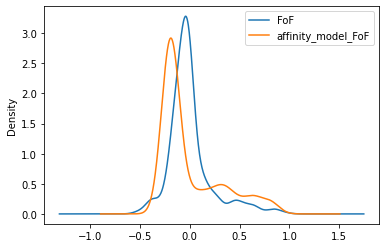

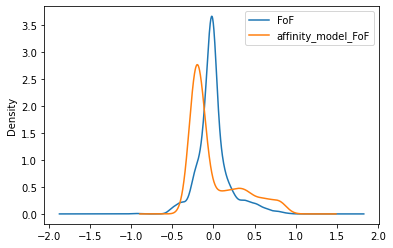

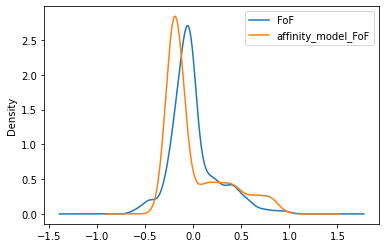

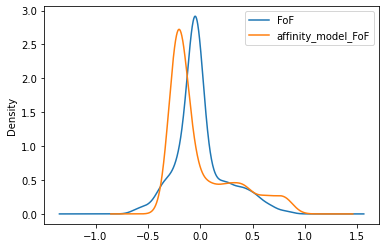

In [114]:
def plot_best_affinity_model(jury_or_tele, the_year, the_mu, the_sigma, the_alpha):
    best_affinity_model = AffinityModel(jury_or_televoting=jury_or_tele, year=the_year, mu=the_mu, sigma=the_sigma, alpha=the_alpha)

    best_affinity_model.step()
    best_affinity_model.df[["FoF", "affinity_model_FoF"]].plot.kde()


plot_best_affinity_model("T", 2021, -0.06, 0.0, 0.5)
plot_best_affinity_model("T", 2022, 0.05, 0.0, 0.25)


plot_best_affinity_model("J", 2021, 0.1, 0.0, 0.5)
plot_best_affinity_model("J", 2022, -0.1, 0.0, 0.25)

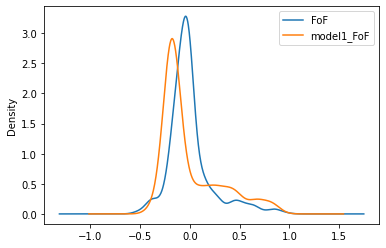

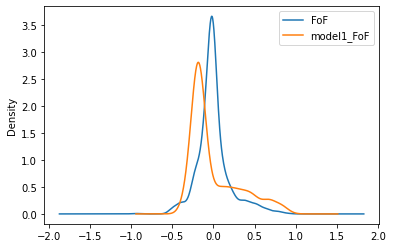

In [99]:
def plot_best_model1_model(the_year):
    best_model1_model = Model1Model(jury_or_televoting="T", year=the_year)

    best_model1_model.step()
    best_model1_model.df[["FoF", "model1_FoF"]].plot.kde()


plot_best_model1_model(2021)
plot_best_model1_model(2022)

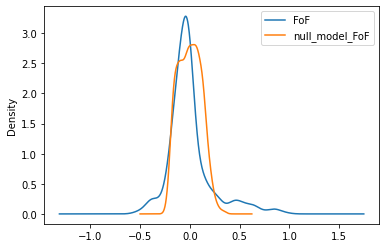

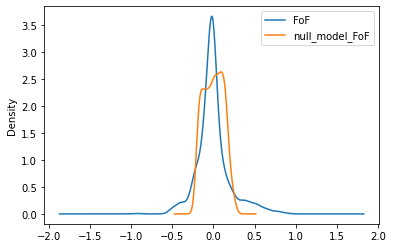

In [101]:
def plot_best_null_model(the_year):
    best_null_model = NullVotingModel(jury_or_televoting="T", year=the_year)

    best_null_model.step()
    best_null_model.df[["FoF", "null_model_FoF"]].plot.kde()


plot_best_null_model(2021)
plot_best_null_model(2022)